In [45]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
from datetime import datetime
plt.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv('NYPD_7_Major_Felony_Incident_Map.csv')
data.head()

,OBJECTID,Identifier,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,CompStat Year,Offense,Offense Classification,Sector,Precinct,Borough,Jurisdiction,XCoordinate,YCoordinate,Location 1
0,1,f070032d,09/06/1940 07:30:00 PM,Friday,Sep,6,1940,19,9,7,2010,BURGLARY,FELONY,D,66,BROOKLYN,N.Y. POLICE DEPT,987478,166141,"(40.6227027620001, -73.9883732929999)"
1,2,c6245d4d,12/14/1968 12:20:00 AM,Saturday,Dec,14,1968,0,12,14,2008,GRAND LARCENY,FELONY,G,28,MANHATTAN,N.Y. POLICE DEPT,996470,232106,"(40.8037530600001, -73.955861904)"
2,3,716dbc6f,10/30/1970 03:30:00 PM,Friday,Oct,30,1970,15,10,31,2008,BURGLARY,FELONY,H,84,BROOKLYN,N.Y. POLICE DEPT,986508,190249,"(40.688874254, -73.9918594329999)"
3,4,638cd7b7,07/18/1972 11:00:00 PM,Tuesday,Jul,18,1972,23,7,19,2012,GRAND LARCENY OF MOTOR VEHICLE,FELONY,F,73,BROOKLYN,N.Y. POLICE DEPT,1005876,182440,"(40.6674141890001, -73.9220463899999)"
4,5,6e410287,05/21/1987 12:01:00 AM,Thursday,May,21,1987,0,5,28,2009,GRAND LARCENY,FELONY,K,75,BROOKLYN,N.Y. POLICE DEPT,1017958,182266,"(40.6668988440001, -73.878495425)"


In [288]:
dslice = data[(data["Occurrence Year"] <= 2015) &
              (data["Occurrence Year"] > 2005) &
              (data["Borough"] == "MANHATTAN") &
              (data["Offense"] == "ROBBERY")]
dslice = dslice[["CompStat Year", "CompStat Month"]]
dslice["count"] = 1
dslice_grouped = dslice.groupby(["CompStat Year", "CompStat Month"]).aggregate(np.sum)

In [289]:
dslice_grouped.head()

count
CompStat Year CompStat Month       
2006          1                 430
              2                 318
              3                 352
              4                 350
              5                 402

In [290]:
indvalues = dslice_grouped.index.get_values()
def foo(x):
    year, month = x
    return datetime(int(year), int(month), 1)
vfoo = np.vectorize(foo)
date_array = vfoo(indvalues)
date_col = pd.Series(date_array, name="date")
count_col = dslice_grouped["count"]
count_col = pd.Series(count_col.values, name="count")
ts = pd.DataFrame(date_col)
ts["count"] = count_col
ts = ts.set_index("date")
ts.head()

,count
date,
2006-01-01,430
2006-02-01,318
2006-03-01,352
2006-04-01,350
2006-05-01,402


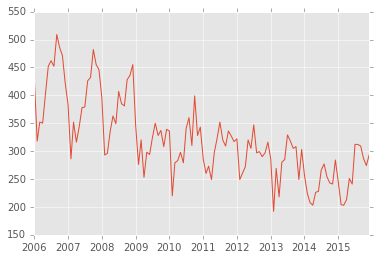

In [291]:
plt.plot(ts)

Видим, что временной ряд нестационарный, имеет отрицательный тренд, ежегодные сезонные колебания (пик ограблений приходится на конец или середину года). Также можно сделать предположение о гетероскедастичности данного ряда (дисперсия убывает со временем). Исследуем автокорреляцию ряда 

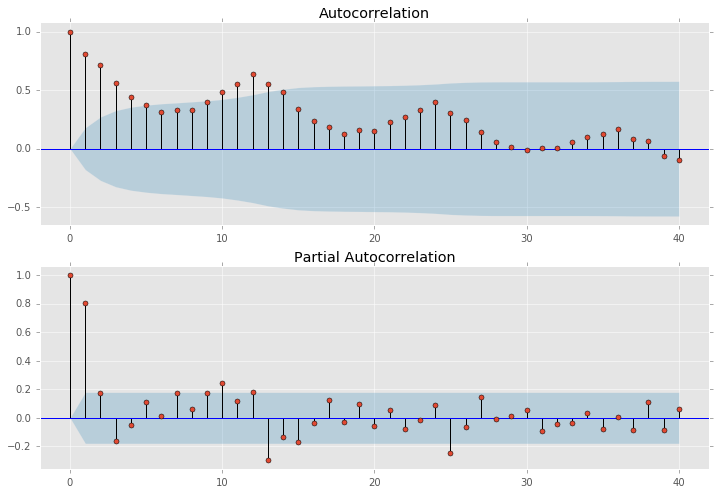

In [78]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)

Тренд и сезонные колебания хорошо видны на функции автокорреляции - она убывает медленно и является периодической с периодом в 12 лагов (1 год). Применим логарифмическое преобразование, чтобы нивелировать гетероскедастичность.

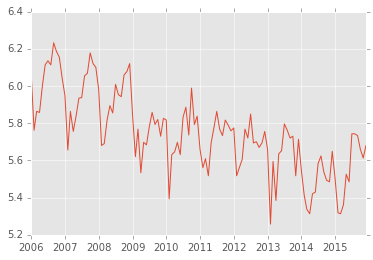

In [292]:
ts_log = np.log(ts)
plt.plot(ts_log)

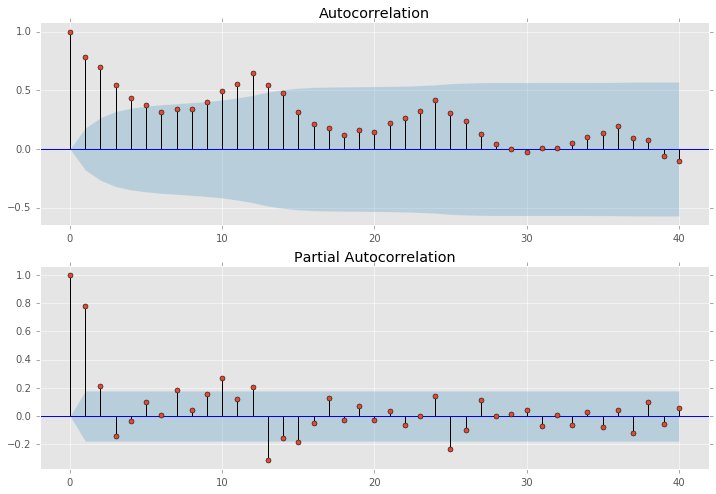

In [91]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log, lags=40, ax=ax2)

Используем тест Дики-Фуллера для формального определения стационарности

In [83]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries["count"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in dftest[4].items():
    #    dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

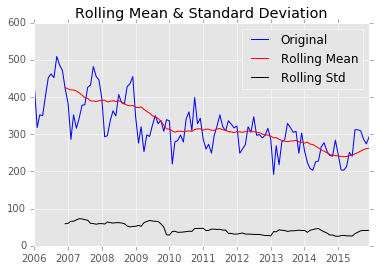

Results of Dickey-Fuller Test:
Test Statistic                  -1.572284
p-value                          0.497499
#Lags Used                      13.000000
Number of Observations Used    106.000000
dtype: float64


In [86]:
test_stationarity(ts)

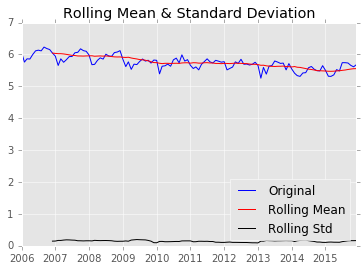

Results of Dickey-Fuller Test:
Test Statistic                  -1.310532
p-value                          0.624340
#Lags Used                      13.000000
Number of Observations Used    106.000000
dtype: float64


In [87]:
test_stationarity(ts_log)

Налицо нестационарность - p-value сильно отличается от нуля

Для устранения тренда будем брать разности ряда

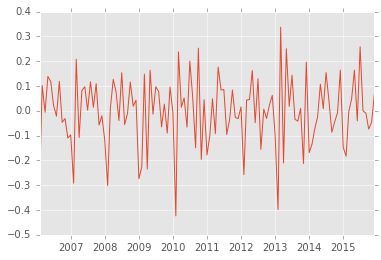

In [88]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)

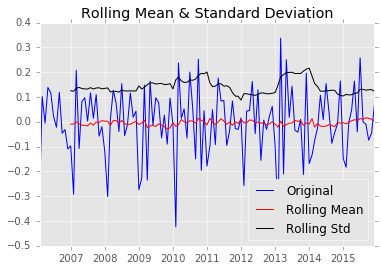

Results of Dickey-Fuller Test:
Test Statistic                  -2.681425
p-value                          0.077308
#Lags Used                      13.000000
Number of Observations Used    105.000000
dtype: float64


In [89]:
test_stationarity(ts_log_diff)

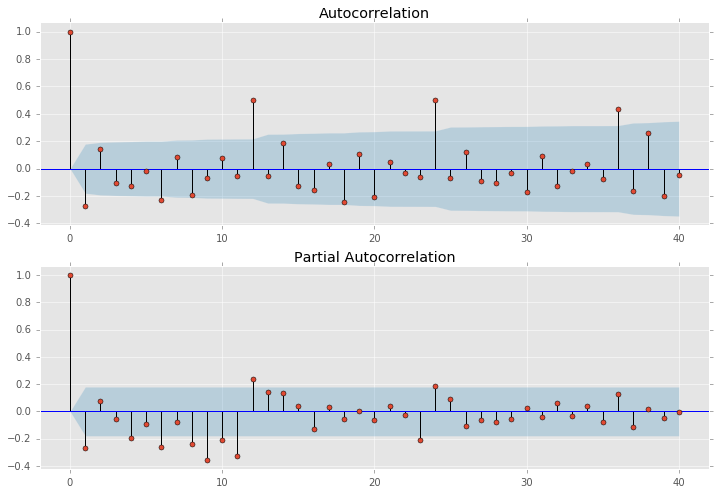

In [90]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=40, ax=ax2)

На графике автокорелляции мы видим, что влияние тренда нивелировано, осталось только сезонная составляющая (через каждые 12 лагов автокорелляция имеет локальный максимум)

Теперь займемся устранением сезонной составляющей, воспользуемся стандартными средствами statmodels

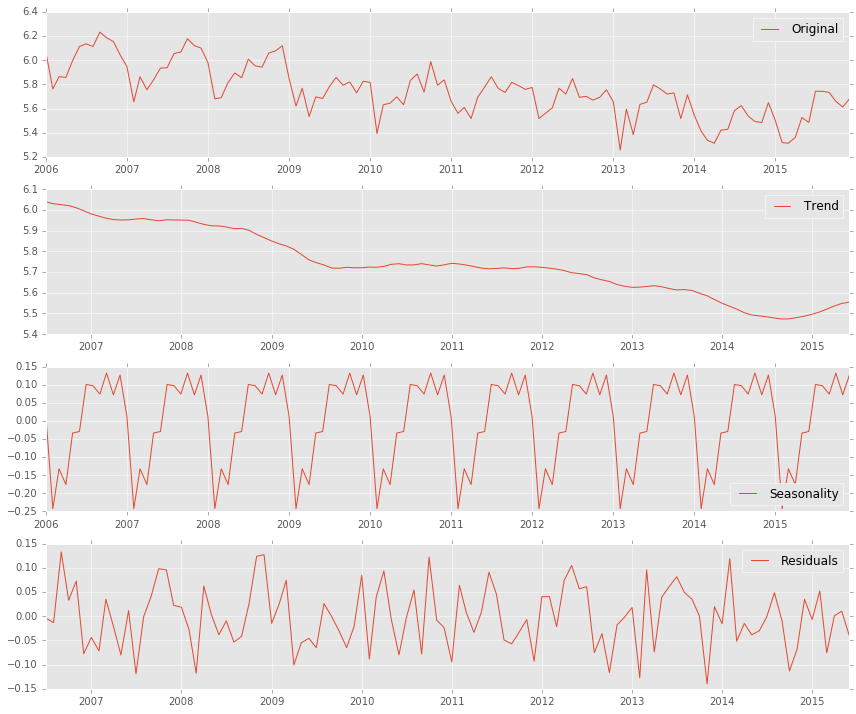

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_log = ts_log.dropna()
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

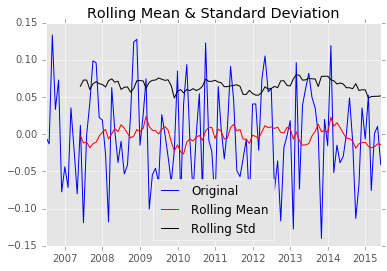

Results of Dickey-Fuller Test:
Test Statistic                 -5.191878
p-value                         0.000009
#Lags Used                     11.000000
Number of Observations Used    96.000000
dtype: float64


In [107]:
test_stationarity(res)

Видим, что после разложения остатки стационарны

Теперь подберем параметры модели ARIMA для остатков. Порядок интеграции равен нулю, т.к. тренда нет.

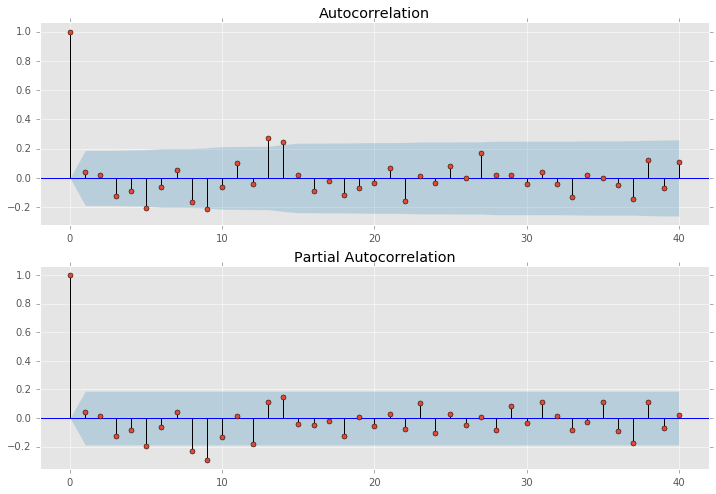

In [108]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res, lags=40, ax=ax2)

После первого лага частная фукнция автокорреляции падает практически до нуля, поэтому возьмем параметры (1, 0, 1), далее если результаты нас не удовлетворят, увеличим порядки модели.

In [175]:
model = sm.tsa.ARIMA(res, order=(1,0,1))
fmodel = model.fit(method="mle")
fmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  count   No. Observations:                  108
Model:                     ARMA(1, 1)   Log Likelihood                 144.849
Method:                           mle   S.D. of innovations              0.063
Date:                Fri, 27 May 2016   AIC                           -281.697
Time:                        11:08:41   BIC                           -270.969
Sample:                    07-01-2006   HQIC                          -277.347
                         - 06-01-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.0014      0.006     -0.215      0.830        -0.014     0.011
ar.L1.count     0.0941      0.823      0.114      0.909        -1.520     1.708
ma.L1.count    -0.0522      0.821     -0.064      0.949        -1.662     1.557
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           10.6288           +0.0000j           10.6288            0.0000
MA.1           19.1662           +0.0000j           19.1662            0.0000
-----------------------------------------------------------------------------
"""

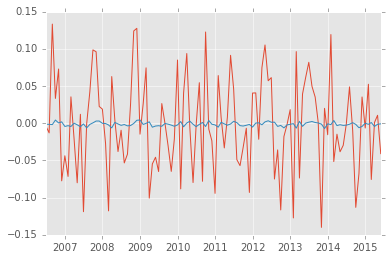

In [178]:
insample_predict=fmodel.predict()
plt.plot(res)
plt.plot(insample_predict)

In [182]:
model = sm.tsa.ARIMA(res, order=(2,0,1))
fmodel = model.fit(method="mle")
fmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  count   No. Observations:                  108
Model:                     ARMA(2, 1)   Log Likelihood                 145.114
Method:                           mle   S.D. of innovations              0.063
Date:                Fri, 27 May 2016   AIC                           -280.229
Time:                        11:10:28   BIC                           -266.818
Sample:                    07-01-2006   HQIC                          -274.791
                         - 06-01-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.0014      0.007     -0.218      0.828        -0.014     0.011
ar.L1.count    -0.5763      0.407     -1.416      0.160        -1.374     0.222
ar.L2.count     0.0812      0.096      0.845      0.400        -0.107     0.270
ma.L1.count     0.6190      0.399      1.551      0.124        -0.163     1.401
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4420           +0.0000j            1.4420            0.5000
AR.2            8.5369           +0.0000j            8.5369            0.0000
MA.1           -1.6156           +0.0000j            1.6156            0.5000
-----------------------------------------------------------------------------
"""

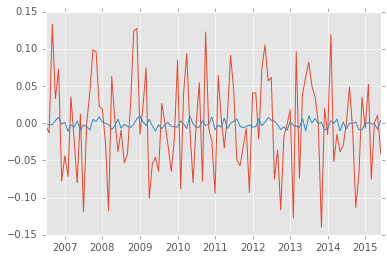

In [180]:
insample_predict=fmodel.predict()
plt.plot(res)
plt.plot(insample_predict)

Похоже, что выполнить качественное предсказание остатков невозможно. По крайней мере, при помощи модели ARIMA. Значит, будем работать с трендом и сезонной составляющей, которые обладают предсказуемостью. Смоделируем тренд при помощи обобщенной линейной регрессионной модели, добавим к нему сезонную составляющую, в итоге получим модель для ряда.

In [256]:
pred_part = trend
pred_part = pred_part.dropna()

In [257]:
Y = pred_part["count"].values

In [298]:
x0 = np.array(range(len(Y)))
x1 = np.ones(len(Y))
X = np.vstack((x1, x0, x0 * x0, x0 * x0 * x0))
X = X.T

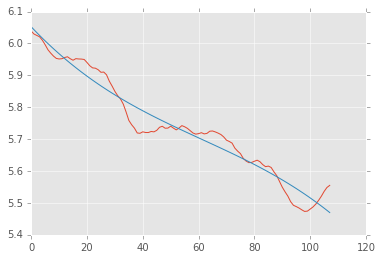

In [299]:
from sklearn.linear_model import LinearRegression

regr_model = LinearRegression()
regr_model.fit(X, Y)
pred = regr_model.predict(X)
plt.plot(Y)
plt.plot(pred)

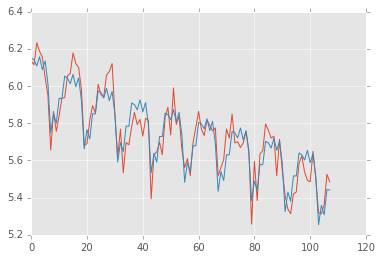

In [300]:
seasonal_adjusted = seasonal.dropna()[6:]
seasonal_adjusted = seasonal_adjusted[:-6]
seasonal_adjusted = seasonal_adjusted["count"].values
plt.plot(Y + seasonal_adjusted + residual.dropna()["count"].values)
plt.plot(pred + seasonal_adjusted)

Теперь предсказательную силу модели можем считать сколь-нибудь удовлетворительной. Сделаем прогноз на год вперед.
Но горизонт прогноза при этом нужно принять не 12 месяцев, а 18. Все потому что после извлечения тренда для него потерялись последние 6 значений. Они не учитывались при построении модели, однако для этого периода фактические значения у нас имеются. Чтобы сделать прогноз на год вперед, мы "предсказываем" еще и эти 6 значений.

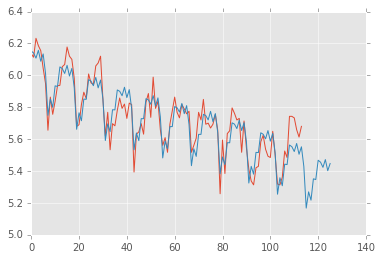

In [302]:
x02 = np.array(range(126))
X2 = np.vstack((np.ones(126), x02, x02 * x02, x02 * x02 * x02))
X2 = X2.T
pred2 = regr_model.predict(X2)
seasonal2 = seasonal.dropna()["count"].values
seasonal2 = seasonal2[6:]
period = seasonal2[:12]
seasonal2 = seasonal2[:-6]
seasonal2 = np.hstack((seasonal2, period, period[:6]))
true = ts_log[6:]["count"].values
forecast = pred2 + seasonal2
plt.plot(true)
plt.plot(forecast)

Сделаем оценку доверительного интервала для прогноза.
Модель строилась на 108 значениях - середине ряда, по ним оценим дисперсию.

In [309]:
N = 108
delta = true[:N] - forecast[:N]
Sy = pow(np.sum(delta * delta) / (108 - 4), 0.5)

In [329]:
forecast_time = np.array(range(12), dtype=np.float64) + N + 6
t1 = (N + 1) / 2
f_time_2 = (forecast_time - t1) * (forecast_time - t1)
tol2 = np.array(range(N)) + 1 - t1
tol2 = np.sum(tol2 * tol2)

In [330]:
tStats = 2.3642

Определяем допуски для доверительного интервала с надежностью 0.95, визуализируем прогноз в пределах доверительных интервалов.

In [335]:
tolerance = tStats * Sy * np.power((N + 1) / N + f_time_2 / tol2, 0.5)
tolerance

array([ 0.18510693,  0.18521003,  0.18531477,  0.18542116,  0.18552918,
        0.18563885,  0.18575014,  0.18586307,  0.18597763,  0.18609381,
        0.18621161,  0.18633103])

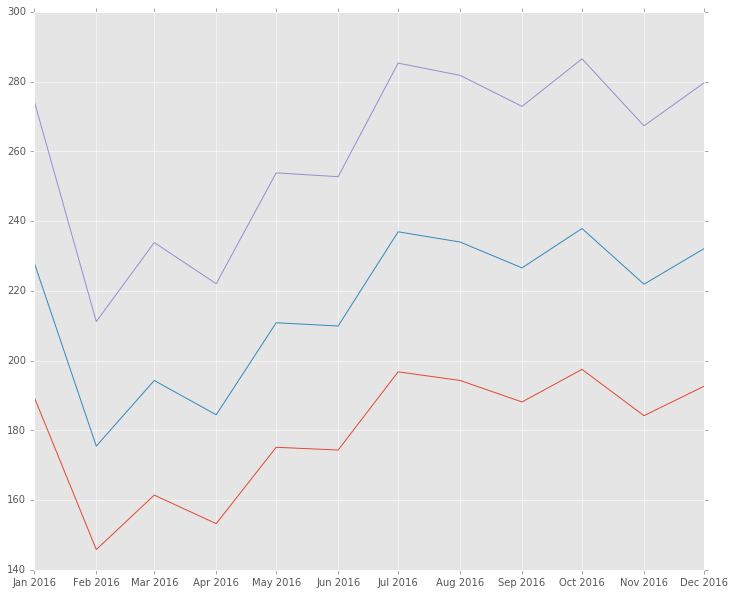

In [339]:
pure_forecast = forecast[-12:]
h_forecast = np.exp(pure_forecast + tolerance)
l_forecast = np.exp(pure_forecast - tolerance)
pure_forecast = np.exp(pure_forecast)

dates = [datetime(2016, 1, 1), datetime(2016, 2, 1),
         datetime(2016, 3, 1), datetime(2016, 4, 1),
         datetime(2016, 5, 1), datetime(2016, 6, 1),
         datetime(2016, 7, 1), datetime(2016, 8, 1),
         datetime(2016, 9, 1), datetime(2016, 10, 1),
         datetime(2016, 11, 1), datetime(2016, 12, 1)]

plt.figure(figsize=(12,10))
plt.plot(pd.Series(l_forecast, index=dates))
plt.plot(pd.Series(pure_forecast, index=dates))
plt.plot(pd.Series(h_forecast, index=dates))

Выводы: полиция Манхэттена работает эффективно. Меры борьбы с преступностю на Манхэттене, в частности, направленные на снижение числа ограблений, результативны. Тренд негативный, логарифмический. Сезонные колебания таковы, что пик числа ограблений приходится на второе полугодие.